In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal Retrieval Augmented Generation (RAG) using Vertex AI Gemini API

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


## Overview

Retrieval augmented generation (RAG) has become a popular paradigm for enabling LLMs to access external data and also as a mechanism for grounding to mitigate against hallucinations.

In this notebook, you will learn how to perform multimodal RAG where you will perform Q&A over a financial document filled with both text and images. 

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini Pro Vision and Gemini Pro models.

### Comparing text-based and multimodal RAG 

Multimodal RAG offers several advantages over text-based RAG:

1. **Enhanced knowledge access:** Multimodal RAG can access and process both textual and visual information, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, multimodal RAG can make better informed inferences across different types of data modalities.

This notebook shows you how to use RAG with Vertex AI Gemini API, [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings), and [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a document search engine. 

Through hands-on examples, you will discover how to construct a multimedia-rich metadata repository of your document sources, enabling search, comparison, and reasoning across diverse information streams.

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contexual answers using both text and images

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python and other dependencies


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, it is recommended to restart the runtime. Run the following cell to restart the current kernel.

The restart process might take a minute or so.


In [33]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

After the restart is complete, continue to the next step.


<div class="alert alert-block alert-warning">
<b>⚠️ Wait for the kernel to finish restarting before you continue. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information


In [ ]:
# Define project information

PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess
    
    PROJECT_ID = subprocess.check_output(["gcloud", "config", "get-value", "project"], text=True).strip()
    
print(f"Your project ID is: {PROJECT_ID}")

In [3]:
import sys

if "google.colab" in sys.modules:
    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [4]:
from IPython.display import Markdown, display
from vertexai.preview.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    Image,
    Part,
)

## Use the Gemini Pro model

The Gemini Pro (`gemini-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.


### Load the Gemini Pro model


In [5]:
model = GenerativeModel("gemini-pro-vision")

### Download custom Python modules and utilities

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [6]:
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")

    
# download the helper scripts from utils folder
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

#### Get documents and images from GCS

In [7]:
# download documents and images used in this notebook
!gsutil -m rsync -r gs://github-repo/rag/intro_multimodal_rag .
print("Synchronization completed")

Building synchronization state...
Starting synchronization...
Copying gs://github-repo/rag/intro_multimodal_rag/text_query_answer_02.png...
Copying gs://github-repo/rag/intro_multimodal_rag/text_query_answer_01.png...   
Copying gs://github-repo/rag/intro_multimodal_rag/class_a_share.png...          
Copying gs://github-repo/rag/intro_multimodal_rag/google-10k-sample-14pages.pdf...
Copying gs://github-repo/rag/intro_multimodal_rag/tac_table_revenue.png...      
/ [5/5 files][823.1 KiB/823.1 KiB] 100% Done                                    
Operation completed over 5 objects/823.1 KiB.                                    
Synchronization completed


## Building metadata of documents containing text and images

### The data

The source data that you will use in this notebook is a modified version of [Google-10K](https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf) which provides a comprehensive overview of the company's financial performance, business operations, management, and risk factors. As the original document is rather large, you will be using [a modified version with only 14 pages](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/google-10k-sample-14pages.pdf) instead. Although it's truncated, the sample document still contains text along with images such as tables, charts, and graphs.

### Import helper functions to build metadata

Before building the multimodal RAG system, it's important to have metadata of all the text and images in the document. For references and citations purposes, the metadata should contain essential elements, including page number, file name, image counter, and so on. Hence, as a next step, you will generate embeddings from the metadata, which will is required to perform similarity search when quering the data.

In [8]:
from utils.intro_multimodal_rag_utils import get_document_metadata

### Extract and store metadata of text and images from a document

You just imported a function called `get_document_metadata()`. This function extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*, as outputs. If you want to find out more about how `get_document_metadata()` function is implemented using Gemini and the embedding models, you can take look at the [source code](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py) directly.

The reason for extraction and storing both text metadata and image metadata is that just by using either of the two alone is not sufficient to come out with a relevent answer. For example, the relevant answers could be in visual form within a document, but text-based RAG won't be able to take into consideration of the visual images. You will also be exploring this example later in this notebook.


At the next step, you will use the function to extract and store metadata of text and images froma document. Please note that the following cell may take a few minutes to complete:

In [10]:
# Specify the PDF path
pdf_path = "google-10k-sample-14pages.pdf"

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table. 
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image:"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    PROJECT_ID,
    model,
    pdf_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    text_emb_text_limit=1000,  # Set text embedding input text limit to 1000 char
)

print("--- Completed processing. ---")

Processing page: 1
Processing page: 2
Extracting image from page: 2, saved as: images/google-10k-sample-14pages.pdf_image_1_0_10.jpeg
Processing page: 3
Extracting image from page: 3, saved as: images/google-10k-sample-14pages.pdf_image_2_0_13.jpeg
Processing page: 4
Extracting image from page: 4, saved as: images/google-10k-sample-14pages.pdf_image_3_0_16.jpeg
Processing page: 5
Extracting image from page: 5, saved as: images/google-10k-sample-14pages.pdf_image_4_0_19.jpeg
Processing page: 6
Processing page: 7
Extracting image from page: 7, saved as: images/google-10k-sample-14pages.pdf_image_6_0_24.jpeg
Extracting image from page: 7, saved as: images/google-10k-sample-14pages.pdf_image_6_1_25.jpeg
Processing page: 8
Extracting image from page: 8, saved as: images/google-10k-sample-14pages.pdf_image_7_0_28.jpeg
Processing page: 9
Processing page: 10
Extracting image from page: 10, saved as: images/google-10k-sample-14pages.pdf_image_9_0_33.jpeg
Processing page: 11
Extracting image fro

#### Inspect the processed text metadata


The follow cell will produce a metadata tabl which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chuck_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [11]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,google-10k-sample-14pages.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.0865528136, -0.0283534508, 0.0130726164, 0....",1,source: https://abc.xyz/assets/investor/static...,"[0.0865528136, -0.0283534061, 0.0130727086, 0...."
1,google-10k-sample-14pages.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.0865528136, -0.0283534508, 0.0130726164, 0....",2,ly. Because many of our shares of Class A comm...,"[0.0293196309, -0.0121876812, 0.0155132757, 0...."
2,google-10k-sample-14pages.pdf,2,Issuer Purchases of Equity Securities\nThe fol...,"[0.0287646223, -0.037768092, 0.0130581614, -0....",1,Issuer Purchases of Equity Securities\nThe fol...,"[0.0287646856, -0.0377680808, 0.0130581697, -0..."
3,google-10k-sample-14pages.pdf,3,The graph below matches Alphabet Inc. Class C'...,"[0.0452729464, -0.030957805, 0.00326117571, 0....",1,The graph below matches Alphabet Inc. Class C'...,"[0.045272883, -0.0309577864, 0.0032611941, 0.0..."
4,google-10k-sample-14pages.pdf,4,Executive Overview\nThe following table summar...,"[-0.0252895746, -0.0315889977, 0.0255003069, 0...",1,Executive Overview\nThe following table summar...,"[-0.025289543, -0.0315889716, 0.0255002975, 0...."


#### Inspect the processed image metadata 

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [12]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_text_desc_and_img,mm_embedding_from_img_only,text_embedding_from_image_description
0,google-10k-sample-14pages.pdf,2,1,images/google-10k-sample-14pages.pdf_image_1_0...,The image is a table that shows the number of...,"[0.0232484732, -0.000801357732, 0.0152797392, ...","[0.0232482236, -0.000801553775, 0.0152807888, ...","[0.0227942783, -0.0256405938, 0.0220476855, -0..."
1,google-10k-sample-14pages.pdf,3,1,images/google-10k-sample-14pages.pdf_image_2_0...,The image shows a line graph comparing the cu...,"[0.00688806782, 0.0237254575, -0.00902903825, ...","[0.00688806782, 0.0237254575, -0.00902903825, ...","[0.0377905257, -0.0554885827, 0.00316507765, 0..."
2,google-10k-sample-14pages.pdf,4,1,images/google-10k-sample-14pages.pdf_image_3_0...,The image shows a graph comparing the cumulat...,"[0.00291747367, 0.0304173753, -0.0221551061, 0...","[0.00291747367, 0.0304173753, -0.0221551061, 0...","[0.0316285789, -0.0483314916, -0.0103542404, 0..."
3,google-10k-sample-14pages.pdf,5,1,images/google-10k-sample-14pages.pdf_image_4_0...,The image is a table that shows the financial...,"[0.0166555811, 0.0199900232, -0.0204026904, -0...","[0.0166557152, 0.019989673, -0.0204030015, -0....","[-0.0112246936, -0.0456144363, 0.0192449335, 0..."
4,google-10k-sample-14pages.pdf,7,2,images/google-10k-sample-14pages.pdf_image_6_1...,The image is a table that shows the revenue o...,"[0.0144325309, 0.023787301, 0.0115119424, -0.0...","[0.0144322757, 0.0237871073, 0.0115118716, -0....","[-0.00100985169, -0.0348161533, 0.0159845818, ..."


### Import the helper functions to implement RAG¶

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` fuction.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.

In [13]:
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)


Before implementing a multimodal RAG, let's take a step back and explore what you can achieve with just text or image embeddings alone. It will help to set the foundation for implementin a multimodel RAG, which you will be doing in the later part of the notebook. You can also use these essential elements together to build applications for multimodal use cases for extracting meaningful information from the document.

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it. The expected answer is to show the value of basic and diluted net income per share of Google for different share types.


In [14]:
query = "I need details for basic and diluted net income per share of Class A, Class B, and Class C share for google?"

### Search similar text with text query

In [15]:
# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    PROJECT_ID,
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    embedding_size=1408,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=True, chunk_text=True)


Citation 1 : Matched text: 

score:  0.59
page_number:  1
chunk_number:  2
chunk_text:  ly. Because many of our shares of Class A common stock and Class C
capital stock are held by brokers and other institutions on behalf of stockholders,
we are unable to estimate the total number of stockholders represented by these
record holders. As of December 31, 2021, there were approximately 64
stockholders of record of our Class B common stock.
Dividend Policy
We have never declared or paid any cash dividend on our common or capital
stock. The primary use of capital continues to be to invest for the long-term
growth of the business. We regularly evaluate our cash and capital structure,
including the size, pace, and form of capital return to stockholders.



Although the response was returned, it didn't return the relevant value, which is basic and diluted net income per share. It is because the information is only available in the images, not text part of the document. This is one of the examples of a standard text search (including text RAG) fails to return relevant information although the information is presence in the document.

Note: We handcrafted examples in our document to simulate real-world cases where information is often embedded in charts, table, graphs, and other image-based elements and unavailable as plain text.  


### Search similar images with text query

Since plain text search didn't provide the desired answer and the information may be visually represented in a table or another image format, you will use multimodal capability of Gemini Pro Vision model for the similar task. The goal here also is to find an image similar to the text query. You may also print the citations to verify.


 **** Result: ***** 



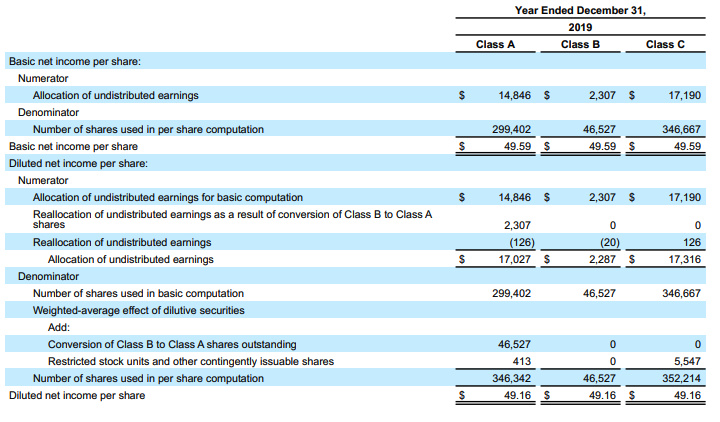

In [16]:
matching_results_image = get_similar_image_from_query(
    PROJECT_ID,
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])


Bingo! It found exactly what you were looking for. You wanted the details on Google's Class A, B, and C shares' basic and diluted net income, and guess what? This image fit the bill perfectly thanks to its descriptive metadata using Gemini.

You can also see the citation and check what Gemini extracted as a description for the top result.

In [17]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1 : Mached image path, page number and page text: 

score:  0.57
path:  images/google-10k-sample-14pages.pdf_image_9_0_33.jpeg
page number:  10
page text:  Board of Directors. As a result, the undistributed earnings for each year are
allocated based on the contractual participation rights of the Class A, Class B,
and Class C stock as if the earnings for the year had been distributed. As the
liquidation and dividend rights are identical, the undistributed earnings are
allocated on a proportionate basis.
In the years ended December 31, 2019, 2020 and 2021, the net income per
share amounts are the same for Class A, Class B, and Class C stock because
the holders of each class are entitled to equal per share dividends or distributions
in liquidation in accordance with the Amended and Restated Certificate of
Incorporation of Alphabet Inc.
The following tables set forth the computation of basic and diluted net income per
share of Class A, Class B, and Class C stock (in millions, exce

<IPython.core.display.Markdown object>

## Image Search

### Search similar image with image query

Imagine searching for images, but instead of typing words, you use an actual image as the clue. You have a table with numbers about the cost of revenue for two years, and you want to find other images that look like it, from the same document or across multiple documents.

Think of it like searching with a mini-map instead of a written address. It's a different way to ask, "Show me more stuff like this". So, instead of typing "cost of revenue 2020 2021 table", you show a picture of that table and say, "Find me more like this"

For demonstration purposes, we will only be finding similar images that show the cost of revenue or similar values in a single document below. However, you can scale this design pattern to match (find relevant images) across multiple documents.

***Input image from user:***


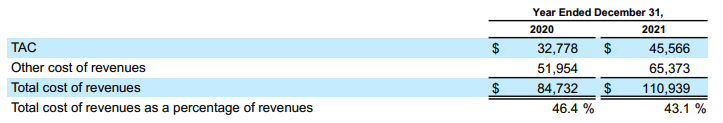

In [18]:
# You can find a similar image as per the images you have in the metadata.
# In this case, you have a table (picked from the same document source) and you would like to find similar tables in the document.
image_query_path = "tac_table_revenue.png"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)


You expect to find tables (as images) that are similar in terms of "Other/Total cost of revenues."


 **** Result: ***** 



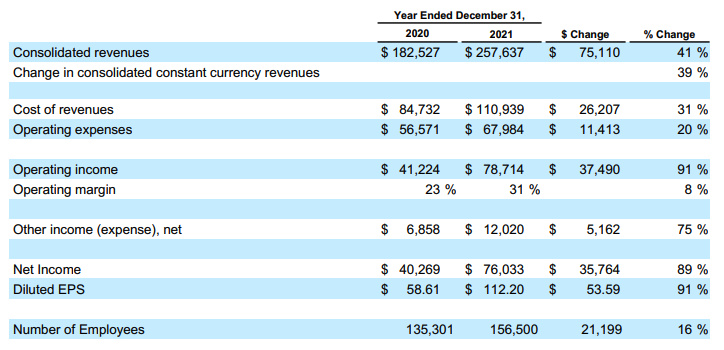

In [19]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    PROJECT_ID,
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)


It did find a similar-looking image (table), which gives more detail about different revenue, expenses, income, and a few more details based on the given image. More importantly, both tables show numbers related to the "cost of revenue."

You can also print the citation to see what it has matched.

In [35]:
# Display citation details for the top matching image
print_text_to_image_citation(matching_results_image, print_top=True)  # Print citation details for the top matching image

Citation 1 : Mached image path, page number and page text: 

score:  0.77
path:  images/google-10k-sample-14pages.pdf_image_4_0_19.jpeg
page number:  5
page text:   Revenues were $257.6 billion, an increase of 41%. The increase in
revenues was primarily driven by Google Services and Google Cloud. The
adverse effect of COVID-19 on 2020 advertising revenues also contributed
to the year-over-year growth.
 Cost of revenues was $110.9 billion, an increase of 31%, primarily driven
by increases in TAC and content acquisition costs.
 An overall increase in data centers and other operations costs was partially
offset by a reduction in depreciation expense due to the change in the
estimated useful life of our servers and certain network equipment. 
Operating expenses were $68.0 billion, an increase of 20%, primarily
driven by headcount growth, increases in advertising and promotional
expenses and charges related to legal matters.
Other information:
 Operating cash flow was $91.7 billion, primari

---------------Matched Images------------------



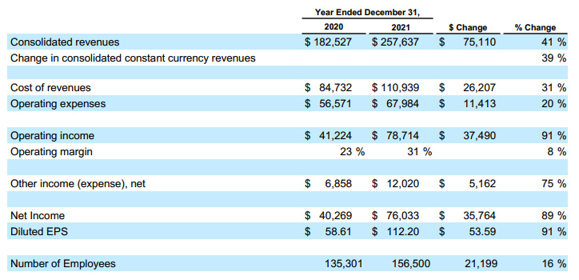

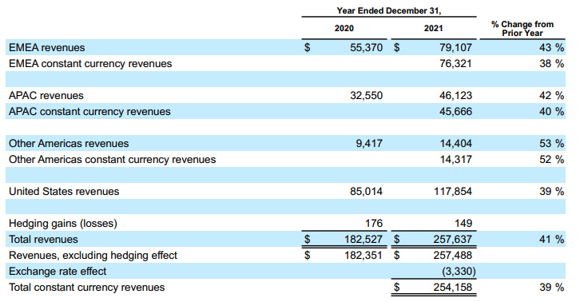

In [41]:
# Check Other Matched Images (Optional)
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image[0]["img_path"],
        matching_results_image[1]["img_path"],
    ],
    resize_ratio = 0.8
)

The ability to identify similar text and images based on user input, powered by Gemini and embeddings, forms a crucial foundation for development of multimodal RAG systems, which you explore in the next section.

### Comparative reasoning

Imagine you have a graph showing how Class A Google shares did compared to other things like the S&P 500 or other tech companies. You want to know how Class C shares did compared to that graph. Instead of just finding another similar image, you can ask Gemini to compare the relavant images and tell you which stock might be better for you to invest in. Gemini would then explain why it thinks that way.

The goal is to send a reference image (Class. A Google shares) and ask simple reasoning questions like "How is this compared to Class C shares?". You expect the image embeddings to find the image of Class C shares and then send both the reference image (Class A share) and the similar image (Class C share) to Gemini and do a comparative reasoning.


***Input image from user:***


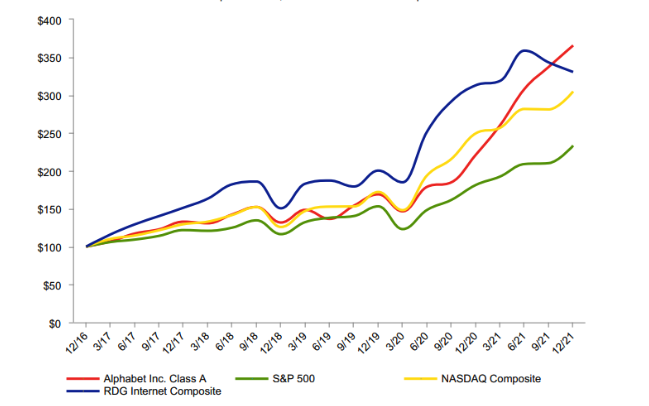

In [22]:
image_query_path = "class_a_share.png"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)


In [23]:
# Load the input image using Pillow
user_image_object = Image.load_from_file(image_query_path)

# Define the comparison query
compare_query = """Question: How has nasdaq performed with respect to Class A and Class B shares of Google?
Answer: """
instructions = """instructions: Compare two images and base your reasoning only on the images provided.
Provide detail reasoning of your conclusions.
Images: """

# Find similar images based on the input image
image_selected_based_on_source_image = get_similar_image_from_query(
    PROJECT_ID,
    text_metadata_df,
    image_metadata_df,
    image_query_path=image_query_path,
    column_name="mm_embedding_from_img_only",
    image_emb=True,
    top_n=3,
    embedding_size=1408,
)

# Select the best matching image from the search results
selected_image_object = image_selected_based_on_source_image[0]["image_object"]

# Prepare the model input
model_input = [instructions, user_image_object, selected_image_object, compare_query]

# Generate Gemini response with streaming output
Markdown(get_gemini_response(model, model_input=model_input, stream=True))


 The cumulative total return of Class A shares of Google has outperformed the cumulative total return of both the Nasdaq Composite and Class C shares of Google.

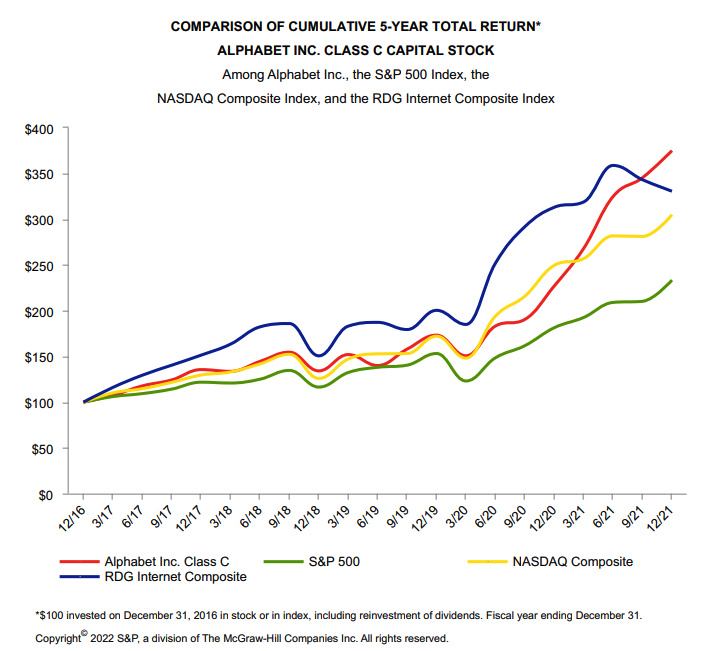

In [24]:
# image selected by the model to make the comparision based on user query
Image.load_from_file(image_selected_based_on_source_image[0]["img_path"])


With Gemini, not only did it find the Google Class C share image, but also did a comparative reasoning and provide a contextual answer to the user query with proper reasoning. You can also make the reasoning more grounded by passing the image descriptions and page text (text available around the graphs) so that there are fewer hallucination chances.


In [25]:
# citations
print_text_to_image_citation(image_selected_based_on_source_image, print_top=True)

Citation 1 : Mached image path, page number and page text: 

score:  0.75
path:  images/google-10k-sample-14pages.pdf_image_3_0_16.jpeg
page number:  4
page text:  Executive Overview
The following table summarizes consolidated financial results for the years ended
December 31, 2020 and 2021 unless otherwise specified (in millions, except for
per share information and percentages):

image description:   The image shows a graph comparing the cumulative 5-year total return of Alphabet Inc. Class C stock, the S&P 500, the NASDAQ Composite Index, and the RDG Internet Composite Index. The graph spans from December 2016 to December 2021.

The cumulative 5-year total return of Alphabet Inc. Class C stock outperformed all other indices, with a return of over 350% by December 2021. The S&P 500 and the NASDAQ Composite Index had a return of around 120% and 180%, respectively, during the same period. The RDG Internet Composite Index had the lowest return, with around 100%.

In summary, Alphabet In


<div class="alert alert-block alert-warning">
<b>⚠️ Disclaimer: This is not a real investment advise and should not be taken seriously!! ⚠️</b>
</div>


## Multimodal retrieval augmented generation (RAG)

Let's bring everything together to implement multimodal RAG. You will use all the elements that you've explored in previous sections to implement the multimodal RAG. These are the steps:

* **Step 1:** The user gives a query in text format where the expected information is available in the document and is embedded in images and text.
* **Step 2:** Find all text chunks from the pages in the documents using a method similar to the one you explored in `Text Search`.
* **Step 3:** Find all similar images from the pages based on the user query matched with `image_description` using a method identical to the one you explored in `Image Search`.
* **Step 4:** Combine all similar text and images found in steps 2 and 3 as `context_text` and `context_images`.
* **Step 5:** With the help of Gemini, we can pass the user query with text and image context found in steps 2 & 3. You can also add a specific instruction the model should remember while answering the user query.
* **Step 6:** Gemini produces the answer, and you can print the citations to check all relevant text and images used to address the query.

### Step 1: User query

In [26]:
# this time we are not passing any images, but just a simple text query.

query = """Question: How has nasdaq and s&p performed with respect to class A shares and class C shares?
Which one would be better to buy and why?
Answer: """

# query = """Question: Find the total revenues and other related financial numbers for Alphabet
# Answer: """

### Step 2: Get all relevant text chunks

In [27]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    PROJECT_ID,
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=5,
    embedding_size=1408,
    chunk_text=True,
)


### Step 3: Get all relevant images

In [28]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    PROJECT_ID,
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=3,
    embedding_size=1408,
)


### Step 4: Create context_text and context_images

In [29]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )


### Step 5: Pass context to Gemini

In [30]:
instructions = """The context of extraction of destails should be based on the text context given in "text_context" and Image context given in "image_context" along with its Caption: \n
Base your response on "text_context" and "image_context". Do not use any numbers or percentages that are not present in the "image_context".
Do not include any cumulative total return in the answer. Context: 
"""

final_prompt = [
    query,
    instructions,
    "text_context:",
    "\n".join(context_text),
    "image_context:",
]
final_prompt.extend(context_images)


In [31]:
Markdown(get_gemini_response(model, model_input = final_prompt,stream=True))

 Based on the information provided in the text and image context, Alphabet Inc. Class C shares have outperformed Class A shares over the past 5 years. The cumulative 5-year total return of Alphabet Inc. Class C stock outperformed all other indices, with a return of over 350% by December 2021. The cumulative 5-year total return of Alphabet Inc. Class A common stock also outperformed the S&P 500, the NASDAQ Composite Index, and the RDG Internet Composite Index. However, the total return of Class A shares is lower than Class C shares. 

In terms of share repurchases, the company has repurchased more Class C shares than Class A shares in the fourth quarter of 2021. The total number of Class C shares repurchased was 4,007,000, while the total number of Class A shares repurchased was 665,000. This indicates that the company is more focused on repurchasing Class C shares than Class A shares.

Based on the information provided, it would be better to buy Class C shares of Alphabet Inc. as they have outperformed Class A shares in terms of total return and the company is repurchasing more Class C shares than Class A shares.

---------------Matched Images------------------



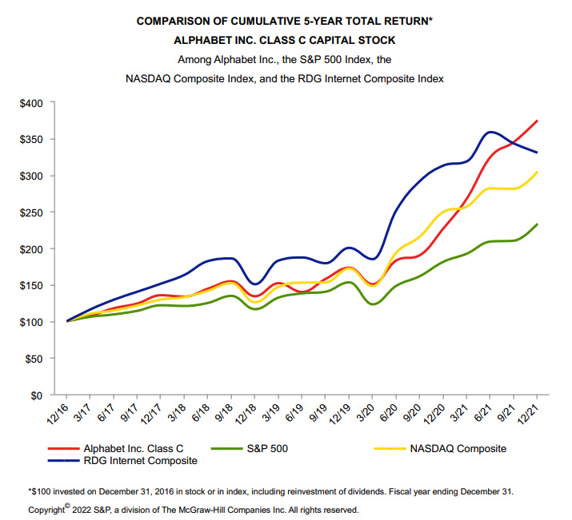

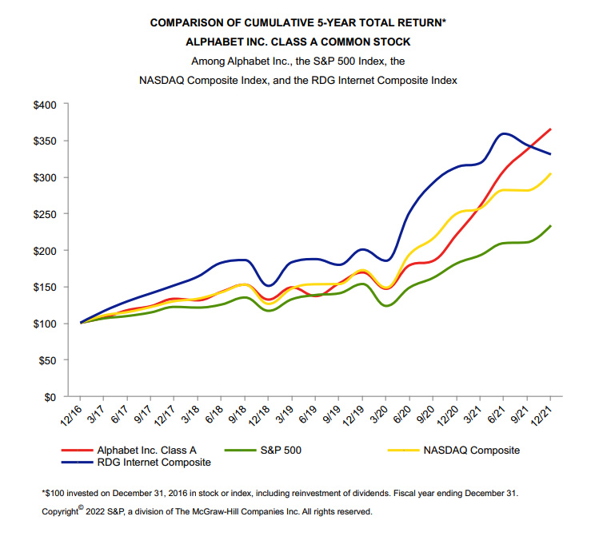

In [42]:
print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_fromdescription_data[0]["img_path"],
        matching_results_image_fromdescription_data[1]["img_path"],
    ],
    resize_ratio = 0.8
)


### Step 6: Print citations and references

In [33]:
# Image citations. You can check how Gemini generated metadata helped in grounding the answer.

print_text_to_image_citation(matching_results_image_fromdescription_data, print_top=False)

Citation 1 : Mached image path, page number and page text: 

score:  0.6
path:  images/google-10k-sample-14pages.pdf_image_3_0_16.jpeg
page number:  4
page text:  Executive Overview
The following table summarizes consolidated financial results for the years ended
December 31, 2020 and 2021 unless otherwise specified (in millions, except for
per share information and percentages):

image description:   The image shows a graph comparing the cumulative 5-year total return of Alphabet Inc. Class C stock, the S&P 500, the NASDAQ Composite Index, and the RDG Internet Composite Index. The graph spans from December 2016 to December 2021.

The cumulative 5-year total return of Alphabet Inc. Class C stock outperformed all other indices, with a return of over 350% by December 2021. The S&P 500 and the NASDAQ Composite Index had a return of around 120% and 180%, respectively, during the same period. The RDG Internet Composite Index had the lowest return, with around 100%.

In summary, Alphabet Inc

In [34]:
# Text citations

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)


Citation 1 : Matched text: 

score:  0.59
page_number:  1
chunk_number:  2
chunk_text:  ly. Because many of our shares of Class A common stock and Class C
capital stock are held by brokers and other institutions on behalf of stockholders,
we are unable to estimate the total number of stockholders represented by these
record holders. As of December 31, 2021, there were approximately 64
stockholders of record of our Class B common stock.
Dividend Policy
We have never declared or paid any cash dividend on our common or capital
stock. The primary use of capital continues to be to invest for the long-term
growth of the business. We regularly evaluate our cash and capital structure,
including the size, pace, and form of capital return to stockholders.

Citation 2 : Matched text: 

score:  0.58
page_number:  2
chunk_number:  1
chunk_text:  Issuer Purchases of Equity Securities
The following table presents information with respect to Alphabet's repurchases
of Class A common stock and Class C c

## Conclusions

Congratulations on making it through this multimodal RAG notebook! 

While multimodal RAG can be quite powerful, note that it can face some limitations:

* **Data dependency:** Needs high-quality paired text and visuals.
* **Computationally demanding:** Processing multimodal data is resource-intensive.
* **Domain specific:** Models trained on general data may not shine in specialized fields like medicine.
* **Black box:** Understanding how these models work can be tricky, hindering trust and adoption.


Despite these challenges, multimodal RAG represents a significant step towards search and retrieval systems that can handle diverse, multimodal data.